In [1]:
import pandas as pd
import tensorflow as tf
from sklearn import metrics
from sklearn.model_selection import train_test_split

In [2]:
df = pd.read_csv('titanic.csv')
print(df.head())
print("///")
print(df.describe())

   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S  
//

In [3]:
df.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [4]:

y = df['Survived']
X = df.drop(['Survived','Name','PassengerId','Ticket'],axis=1)

In [5]:
male_age_avg = X[X['Sex']=='male']['Age'].mean()
female_age_avg = X[X['Sex']=='female']['Age'].mean()

In [6]:
X.loc[(X['Sex']=='male') & (X['Age'].isnull()),'Age'] = male_age_avg
X.loc[(X['Sex']=='female') & (X['Age'].isnull()),'Age'] = female_age_avg

In [7]:
print("Male Avg Age {}".format(male_age_avg))
print("FeMale Avg Age {}".format(female_age_avg))

Male Avg Age 30.72664459161148
FeMale Avg Age 27.915708812260537


In [8]:
X['Cabin'] = X['Cabin'].fillna('X')
X['Embarked'] = X['Embarked'].fillna('S')


In [9]:
X.isna().sum()

Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Cabin       0
Embarked    0
dtype: int64

In [10]:
X_train,X_test,y_train,y_test = train_test_split(X,y,train_size=0.75,random_state=1)

### Generating TF Feature Columns

In [11]:
X_train.tail()

,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
715,3,male,19.000000,0,0,7.65,F G73,S
767,3,female,30.500000,0,0,7.75,X,Q
72,2,male,21.000000,0,0,73.50,X,S
235,3,female,27.915709,0,0,7.55,X,S
37,3,male,21.000000,0,0,8.05,X,S


In [12]:
pclass_feature = tf.feature_column.numeric_column('Pclass')
parch_feature = tf.feature_column.numeric_column('Parch')
fare_feature = tf.feature_column.numeric_column('Fare')
age_feature = tf.feature_column.numeric_column('Age')
sib_feature = tf.feature_column.numeric_column('SibSp')

# bucket for aging groups
age_bucket_feature = tf.feature_column.bucketized_column(age_feature,[12,21,60])

# defining sex as categorical feature with predefined value
sex_feature = tf.feature_column.categorical_column_with_vocabulary_list('Sex',
                                                                        ['female','male'])

# defining dynamic value categoric column
embark_feature = tf.feature_column.categorical_column_with_hash_bucket('Embarked',3)

cabin_feature = tf.feature_column.categorical_column_with_hash_bucket('Cabin',100)

feature_columns = [pclass_feature,age_feature,parch_feature,fare_feature,age_bucket_feature,embark_feature,cabin_feature,sib_feature]


### Linear Classifier Estimator

In [13]:
estimator = tf.compat.v1.estimator.LinearClassifier(feature_columns=feature_columns)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpmvr1ggt9', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [14]:
train_input_fn = tf.compat.v1.estimator.inputs.pandas_input_fn(x=X_train
                                                              ,y=y_train,
                                                              num_epochs=None,
                                                              shuffle=True,
                                                              target_column='target'
                                                              )

In [15]:
estimator.train(input_fn=train_input_fn,steps=150)
result = estimator.evaluate(tf.compat.v1.estimator.inputs.pandas_input_fn(x=X_train,y=y_train,batch_size=10,num_epochs=1,shuffle=False))

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Instructions for updating:
Please use `layer.add_weight` method instead.
INF

## Test data evaluation

In [16]:
eval_func = tf.compat.v1.estimator.inputs.pandas_input_fn(x=X_test,y=y_test,batch_size=10,num_epochs=1,shuffle=False)
result = estimator.evaluate(eval_func)
print(result)

INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2020-07-11T20:24:00Z
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpmvr1ggt9/model.ckpt-150
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Inference Time : 0.71675s
INFO:tensorflow:Finished evaluation at 2020-07-11-20:24:01
INFO:tensorflow:Saving dict for global step 150: accuracy = 0.6591928, accuracy_

# Machine Learning


In [32]:
from sklearn.naive_bayes import MultinomialNB,BernoulliNB,GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix,accuracy_score
from sklearn.neighbors import KNeighborsClassifier


In [18]:
print(X.head())

   Pclass     Sex   Age  SibSp  Parch     Fare Cabin Embarked
0       3    male  22.0      1      0   7.2500     X        S
1       1  female  38.0      1      0  71.2833   C85        C
2       3  female  26.0      0      0   7.9250     X        S
3       1  female  35.0      1      0  53.1000  C123        S
4       3    male  35.0      0      0   8.0500     X        S


In [19]:
X = X.drop('Cabin',axis=1)
X['Sex'] = X['Sex'].replace(['female','male'],[0,1])
X['Embarked'] = X['Embarked'].replace(['C','S','Q'],[0,1,2])
X['Age'] = pd.qcut(X['Age'], 10, labels=False)


In [20]:
print(X.head())
X_train,X_test,y_train,y_test = train_test_split(X,y,train_size=0.7,random_state=1)

   Pclass  Sex  Age  SibSp  Parch     Fare  Embarked
0       3    1    2      1      0   7.2500         1
1       1    0    7      1      0  71.2833         0
2       3    0    3      0      0   7.9250         1
3       1    0    7      1      0  53.1000         1
4       3    1    7      0      0   8.0500         1


     Pclass  Sex  Age  SibSp  Parch     Fare  Embarked  Survived
0         3    1    2      1      0   7.2500         1         0
1         1    0    7      1      0  71.2833         0         1
2         3    0    3      0      0   7.9250         1         1
3         1    0    7      1      0  53.1000         1         1
4         3    1    7      0      0   8.0500         1         0
..      ...  ...  ...    ...    ...      ...       ...       ...
886       2    1    3      0      0  13.0000         1         0
887       1    0    1      0      0  30.0000         1         1
888       3    0    3      1      2  23.4500         1         0
889       1    1    3      0      0  30.0000         0         1
890       3    1    6      0      0   7.7500         2         0

[891 rows x 8 columns]


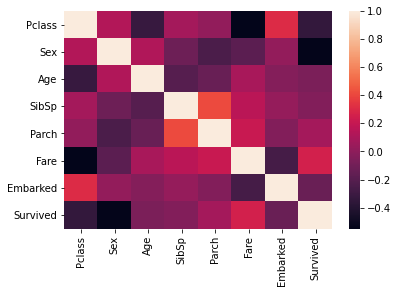

In [21]:
data = X
data['Survived'] = y
print(data)
corrmat = data.corr()
import seaborn as sns
sns.heatmap(corrmat)

In [30]:
nb = MultinomialNB()
nb.fit(X_train,y_train)
prediction = nb.predict(X_test)
print("Accuracy Of Multi NaiveBayes = {}".format(accuracy_score(prediction,y_test)))
print("Consfusion Matrix:")
print(confusion_matrix(prediction,y_test))


nb = BernoulliNB()
nb.fit(X_train,y_train)
prediction = nb.predict(X_test)
print("Accuracy Of Bernoulli NaiveBayes = {}".format(accuracy_score(prediction,y_test)))
print("Consfusion Matrix:")
print(confusion_matrix(prediction,y_test))


nb = GaussianNB()
nb.fit(X_train,y_train)
prediction = nb.predict(X_test)
print("Accuracy Of Gaussian NaiveBayes = {}".format(accuracy_score(prediction,y_test)))
print("Consfusion Matrix:")
print(confusion_matrix(prediction,y_test))

print("On Training Data")
nb1 = GaussianNB()
nb1.fit(X_train,y_train)
prediction = nb.predict(X_train)
print("Accuracy Of Gaussian NaiveBayes = {}".format(accuracy_score(prediction,y_train)))
print("Consfusion Matrix:")
print(confusion_matrix(prediction,y_train))

Accuracy Of Multi NaiveBayes = 0.6492537313432836
Consfusion Matrix:
[[125  66]
 [ 28  49]]
Accuracy Of Bernoulli NaiveBayes = 0.75
Consfusion Matrix:
[[121  35]
 [ 32  80]]
Accuracy Of Gaussian NaiveBayes = 0.7611940298507462
Consfusion Matrix:
[[124  35]
 [ 29  80]]
On Training Data
Accuracy Of Gaussian NaiveBayes = 0.8025682182985554
Consfusion Matrix:
[[328  55]
 [ 68 172]]


In [31]:
neigh = KNeighborsClassifier(n_neighbors=3)
neigh.fit(X_train, y_train)
prediction = neigh.predict(X_test)
print("Accuracy Of KNN = {}".format(accuracy_score(prediction,y_test)))
print("Confusion Matrix:")
print(confusion_matrix(prediction,y_test))

Accuracy Of KNN = 0.7425373134328358
Confusion Matrix:
[[128  44]
 [ 25  71]]


In [33]:
clf = RandomForestClassifier(max_depth=2, random_state=0)
clf.fit(X_train,y_train)
prediction = clf.predict(X_test)
print("Accuracy Of Random Forest = {}".format(accuracy_score(prediction,y_test)))
print("Confusion Matrix:")
print(confusion_matrix(prediction,y_test))
                                          

Accuracy Of Random Forest = 0.753731343283582
Confusion Matrix:
[[143  56]
 [ 10  59]]
